### Imports

In [1]:
import matplotlib.pyplot as plt

# gerrychain
from gerrychain import (GeographicPartition,
                        Partition,
                        Graph,
                        MarkovChain,
                        proposals,
                        updaters,
                        constraints,
                        accept,
                        Election)
from gerrychain.proposals import recom
from gerrychain.tree import recursive_tree_part
from gerrychain.updaters import (Tally,
                                 cut_edges)
from gerrychain.metrics import (efficiency_gap,
                                mean_median,
                                partisan_bias,
                                polsby_popper,
                                partisan_gini)
# County Work
from gerrychain.updaters.county_splits import (CountySplit,
                                               compute_county_splits,
                                               county_splits)

# utils
from functools import partial
import pandas as pd 
import geopandas as gpd

# local script
import edges

# import csv, json
from tqdm import tqdm


get_ipython().run_line_magic('matplotlib', 'inline')

### Read Input Files

In [2]:
# Source Data
# Precs = gpd.read_file("VTDrace/VTDraceMod.shp")
Precs = gpd.read_file("SoLA/SoLA.shp")

In [3]:
# Note: "TOT_NBLACK" created as given input rather than generate by this script

In [4]:
Prec_Graph = Graph.from_geodataframe(Precs.reset_index(), ignore_errors=True)
Prec_Graph.to_json("SoLA_Analyze_Senate_graph.json")
# Prec_Graph.nodes # Inspect nodes, and other NetworkX functions

/home/ryan/.local/lib/python3.8/site-packages/gerrychain/graph/graph.py:162: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  areas = df.geometry.area.to_dict()


In [5]:
# Save Graph?
# graph = Graph.from_json("./PA_VTDs.json")

### Constants

In [6]:
DISTS = 21
TOTPOP = "TOT_POP"
TOLERANCE = .05
TARGET = sum(Precs[TOTPOP])/DISTS
KEY = "GEOID20" # Unique ID
ASSIGN = "District"
NEW_ASSIGN = "D_"
# COUNTY = "COUNTYFP20"
MIN_PLUR = .40
MIN_MAJ = .5

### Updaters

In [7]:
# set updated for Total Population
My_updaters = {
               "population": updaters.Tally(TOTPOP, alias="population"), # }
               # "splits": county_splits("splits", COUNTY),
               # "Hispanic": Election("Hispanic", {"Hispanic": "TOT_HISPAN", "Not-Hispanic": "TOT_NHISP"}),
               "Black": Election("Black", {"Black": "TOT_BLACK", "Not-Black": "TOT_NBLACK"}),
              }

### Initial Partition and Partition Utilities

In [8]:
Initial_Partition = GeographicPartition(Prec_Graph, assignment=ASSIGN, updaters=My_updaters)

In [9]:
def number_black_dists(percents, thresh):  
        perc_list = [ True if dist >= thresh else False for dist in percents]
        return sum(perc_list)

In [11]:
# Tests:

# initial_partition["Black"].percents("Black")
# print(initial_partition["Black"])
# type(initial_partition["population"])
# pd.Series(initial_partition["population"])
# pd.Series(Precs.index.map(dict(initial_partition.assignment)))
# initial_partition["splits"]
# initial_partition.plot(geometries=Precs) # See the Parts
# initial_partition.population # Test
number_black_dists(Initial_Partition["Black"].percents("Black"), MIN_PLUR)

7

### Constraints

In [13]:
# Constraints
# "Up to twice the number of cut edges"
compactness_bound = constraints.UpperBound(
    lambda p: len(p["cut_edges"]),
    2*len(Initial_Partition["cut_edges"])
)

# split_constraint = constraints.refuse_new_splits("splits")

# "Population assignment slack"
# Initial must pass this test
# pop_constraint = constraints.within_percent_of_ideal_population(initial_partition, 0.4)

# majority_constraint = constraints.LowerBound(
#     lambda p: number_black_dists(p["Black"].percents("Black"), MIN_MAJ),
#     number_black_dists(initial_partition["Black"].percents("Black"), MIN_MAJ)
# )

# plurality_constraint = constraints.LowerBound(
#     lambda p: number_black_dists(p["Black"].percents("Black"), MIN_PLUR),
#     number_black_dists(initial_partition["Black"].percents("Black"), MIN_PLUR)
# )

### Proposal and Chain

In [14]:
# Bind default paraters to recom
proposal = partial(recom,
                   pop_col=TOTPOP,
                   pop_target=TARGET,
                   epsilon=TOLERANCE,
                   node_repeats=2
                  )

Chain = MarkovChain(
    proposal=proposal,
    constraints=[
        # pop_constraint,
        compactness_bound,
        # majority_constraint,
        # plurality_constraint
    ],
    accept=accept.always_accept,
    initial_state=Initial_Partition,
    total_steps=40000
)

In [15]:
# Trackers

"""   '''   '''   '''   '''   '''   '''

There are four global varials contained
here, three of which are trackers. 

Data:
For every plan (by ID), Data keeps track
of the sorted Black Population to see what
kind of districts are possible to create.

NewPrecs:
When we decide we like a partition, we
save its assignment as a new column in
newPrecs titled after its ID number.

Steps:
Steps is the same as Data but proportions
are kept for each district, plus other
stats related to total district
characteristics.

We must generate a list of districts as
it is supplied by the initial_partition in
random order.

'''   '''   '''   '''   '''   '''   """


Data = pd.DataFrame([sorted(initial_partition["Black"].percents("Black"))])
NewPrecs = Precs.copy()

Distslist = [f"D{dist}" for dist in initial_partition.parts.keys()]
colslist = [*Distslist, "NumBlackPlur", "NumBlackMaj", "ID"]
Steps = pd.DataFrame(columns=colslist)

NameError: name 'initial_partition' is not defined

In [59]:
# p is partition
for i,p in enumerate(Chain.with_progress_bar()):
    Data = Data.append(pd.DataFrame([sorted(p["Black"].percents("Black"))]))
    
    percs = p["Black"].percents("Black")
    percs_df = pd.DataFrame([percs], columns=[Distslist]) 
    percs_df["ID"] = i
    percs_df["NumBlackPlur"] = number_black_dists(percs, MIN_PLUR)
    percs_df["NumBlackMaj"] = number_black_dists(percs, MIN_MAJ)    
    Steps = Steps.append(percs_df)
    
    # if i % 25 == 0:
    if (number_black_dists(percs, MIN_PLUR) >= 8) & (number_black_dists(percs, MIN_MAJ) >= 6):
        print(i)
        newassign = [[Precs.iloc[precinct].GEOID20,p.assignment[precinct]] for precinct in p.graph.nodes]
        new_df = pd.DataFrame(newassign).rename(columns = {0:KEY,1:f"{NEW_ASSIGN}{i}"}) # .set_index(KEY)
        NewPrecs = NewPrecs.merge(new_df, on=KEY)
        

  0%|          | 0/40000 [00:00<?, ?it/s]

1006
1007
1008
1009
1010
1011
1012
1013
1014
8476
8477
8478
8599
8600
9081
9082
9083
9084
9085
9086
9087
9088
9089
9090
9186
9187
9188
9214
9215
9274
9275
9276
9277
9278
9279
9280
9281
9282
9283
9284
9285
9286
9290
9291


KeyboardInterrupt: 

In [60]:
Steps.to_csv('SoLA-parts-Plur8Maj6.csv')
NewPrecs.to_file("SoLASHP/SoLA-Plur8Maj6.shp")

### Reporting and Charting

In [61]:
# data.to_csv("SELa-SenAnalyze3.csv")
len(Data)

10417

In [40]:
Data.head()

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
0,0.081362,0.094147,0.122233,0.134198,0.159501,0.168325,0.221643,0.246831,0.269358,0.273792,...,0.352313,0.356763,0.35847,0.452077,0.547080,0.56832,0.600115,0.603628,0.611251,0.759133
0,0.081362,0.094147,0.122233,0.134198,0.159501,0.168325,0.221643,0.246831,0.269358,0.273792,...,0.352313,0.356763,0.35847,0.452077,0.547080,0.56832,0.600115,0.603628,0.611251,0.759133
0,0.081362,0.094147,0.122233,0.134198,0.159501,0.168325,0.246831,0.261602,0.269358,0.273792,...,0.352313,0.356763,0.35847,0.452077,0.547080,0.56832,0.573551,0.600115,0.603628,0.759133
0,0.081362,0.094147,0.122233,0.134198,0.159501,0.246831,0.261602,0.269358,0.273792,0.286309,...,0.352313,0.356763,0.35847,0.384303,0.452077,0.56832,0.573551,0.600115,0.603628,0.759133
0,0.081362,0.094147,0.122233,0.134198,0.159501,0.246831,0.261602,0.269358,0.273792,0.286309,...,0.341362,0.352313,0.35847,0.402318,0.452077,0.56832,0.573551,0.600115,0.603628,0.759133


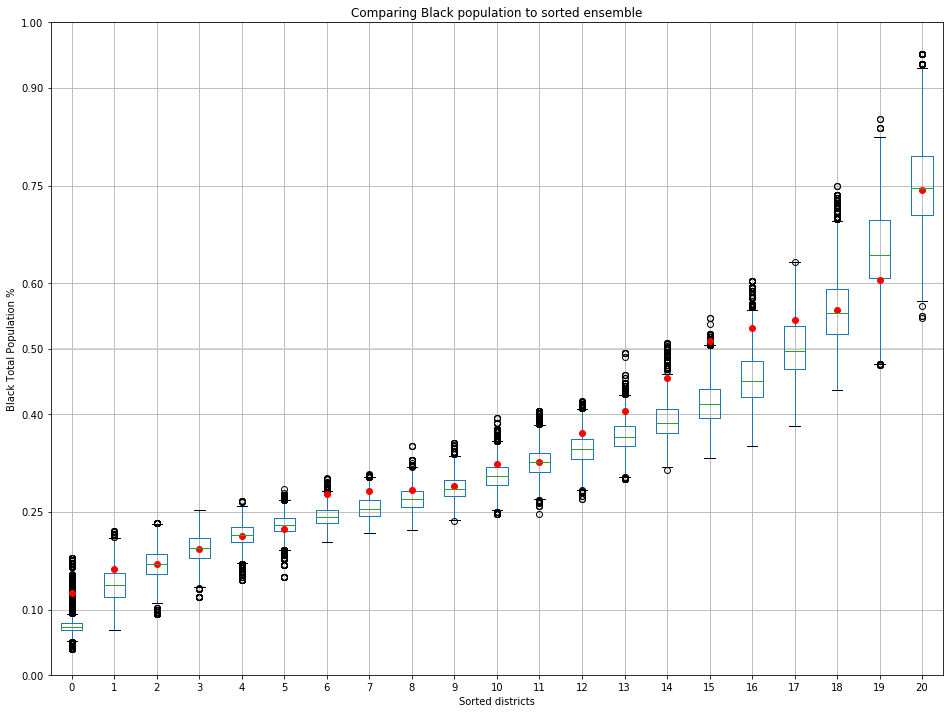

In [63]:
fig, ax = plt.subplots(figsize=(16, 12))

# Draw 50% line
ax.axhline(0.5, color="#cccccc")

# Draw boxplot
data.boxplot(ax=ax, positions=range(len(Data.columns)))

# Draw initial plan's Democratic vote %s (.iloc[0] gives the first row)
plt.plot(Data.iloc[0], "ro")
# plt.plot(data.iloc[9291], "ro")

# Annotate
ax.set_title("Comparing Black population to sorted ensemble")
ax.set_ylabel("Black Total Population %")
ax.set_xlabel("Sorted districts")
ax.set_ylim(0, 1)
ax.set_yticks([0, .10, 0.25, .4,  0.5, .6, 0.75, .9, 1])

plt.show()